In [86]:
#!pip install catboost

In [1]:
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
print(f"catBoost version: {cb.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")

catBoost version: 1.2.2
numpy version: 1.26.0
pandas version: 2.1.1
seaborn version: 0.12.2


In [3]:
print('Loading Properties ...')
properties2016 = pd.read_csv('properties_2016.csv', low_memory = False)
properties2017 = pd.read_csv('properties_2017.csv', low_memory = False)

print('Loading Train ...')
train2016 = pd.read_csv('train_2016_v2.csv', parse_dates=['transactiondate'], low_memory=False)
train2017 = pd.read_csv('train_2017.csv', parse_dates=['transactiondate'], low_memory=False)

print('Loading Sample ...')
sample_submission = pd.read_csv('sample_submission.csv', low_memory = False)

print('Done ...')

Loading Properties ...
Loading Train ...
Loading Sample ...
Done ...


In [4]:
print(properties2016.shape)
print(properties2017.shape)
print(train2016.shape)
print(train2017.shape)
print(sample_submission.shape)

(2985217, 58)
(2985217, 58)
(90275, 3)
(77613, 3)
(2985217, 7)


## Exploring the csvs

In [5]:
train2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,1/1/2016
1,14366692,-0.1684,1/1/2016
2,12098116,-0.0040,1/1/2016
3,12643413,0.0218,2/1/2016
4,14432541,-0.0050,2/1/2016


In [6]:
train2017.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,1/1/2017
1,17052889,0.055619,1/1/2017
2,14186244,0.005383,1/1/2017
3,12177905,-0.103410,1/1/2017
4,10887214,0.006940,1/1/2017


In [7]:
properties2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [8]:
properties2017.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


In [9]:
sample_submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


## Observing sample submission parcelID order

In [10]:
sample_submission["ParcelId"].equals(properties2016["parcelid"])

True

In [11]:
sample_submission["ParcelId"].equals(properties2017["parcelid"])

False

The parcelid order in sample submission seems to follow that of 2016, thus we need to reorder 2017

### Reordering properties2017

In [12]:
properties2017 = pd.merge(sample_submission["ParcelId"], properties2017, how='left', left_on ='ParcelId',right_on='parcelid').drop("ParcelId", axis=1)
properties2017

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,110245.0,226900.0,2016.0,116655.0,3035.26,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,3.0,3.0,NaN,NaN,3.0,NaN,...,NaN,NaN,378466.0,762157.0,2016.0,383691.0,8653.10,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,...,NaN,NaN,201575.0,483188.0,2016.0,281613.0,5671.40,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,NaN,...,NaN,NaN,347863.0,578621.0,2016.0,230758.0,5894.36,NaN,NaN,NaN


In [13]:
sample_submission["ParcelId"].equals(properties2017["parcelid"])

True

## Splitting transaction dates into month, year (removing day)

In [14]:
def split_date(df):
    df["transactiondate"] = pd.to_datetime(df["transactiondate"], dayfirst=True)
    df["transaction_year"] = df["transactiondate"].dt.year
    
#     df["transaction_month"] = df["transactiondate"].dt.month

#     the code below is used if we want to let 2017 jan start as month 13 (might be useful when we combine both years to train a model)
    df["transaction_month"] = (df["transactiondate"].dt.year - 2016)*12 + df["transactiondate"].dt.month

    
#     df["transaction_day"] = df["transactiondate"].dt.day
    
    df.drop(["transactiondate"], inplace=True, axis=1)
    return df

train2016 = split_date(train2016)
train2017 = split_date(train2017)

In [15]:
print(train2016.shape)
train2016.head()

(90275, 4)


,parcelid,logerror,transaction_year,transaction_month
0,11016594,0.0276,2016,1
1,14366692,-0.1684,2016,1
2,12098116,-0.0040,2016,1
3,12643413,0.0218,2016,1
4,14432541,-0.0050,2016,1


In [16]:
print(train2017.shape)
train2017.head()

(77613, 4)


,parcelid,logerror,transaction_year,transaction_month
0,14297519,0.025595,2017,13
1,17052889,0.055619,2017,13
2,14186244,0.005383,2017,13
3,12177905,-0.103410,2017,13
4,10887214,0.006940,2017,13


we can see that Jan 2017 starts as month 13

## Non-Null counts for the columns in properties.csv

In [17]:
properties2016.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   parcelid                      2985217 non-null  int64  
 1   airconditioningtypeid         811519 non-null   float64
 2   architecturalstyletypeid      6061 non-null     float64
 3   basementsqft                  1628 non-null     float64
 4   bathroomcnt                   2973755 non-null  float64
 5   bedroomcnt                    2973767 non-null  float64
 6   buildingclasstypeid           12629 non-null    float64
 7   buildingqualitytypeid         1938488 non-null  float64
 8   calculatedbathnbr             2856305 non-null  float64
 9   decktypeid                    17096 non-null    float64
 10  finishedfloor1squarefeet      202717 non-null   float64
 11  calculatedfinishedsquarefeet  2929652 non-null  float64
 12  finishedsquarefeet12        

## Possible cleaning of dataframe  

 ### 1) remove the features with 1 unique value 

In [18]:
oneUniqueValueList2016 = []

for i in properties2016.columns:
    uniqueNum = properties2016[i].nunique()
    
    if uniqueNum == 1:
        oneUniqueValueList2016.append(i)
    
    
oneUniqueValueList2016

['decktypeid',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'storytypeid',
 'fireplaceflag',
 'taxdelinquencyflag']

In [19]:
oneUniqueValueList2017 = []

for i in properties2017.columns:
    uniqueNum = properties2017[i].nunique()
    
    if uniqueNum == 1:
        oneUniqueValueList2017.append(i)
    
    
oneUniqueValueList2017

['decktypeid',
 'hashottuborspa',
 'poolcnt',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'storytypeid',
 'fireplaceflag',
 'taxdelinquencyflag']

Both 2016 and 2017 have the same columns that only has 1 unique value, thus we will be removing them

### Removing above elements from our df

In [20]:
properties2016.drop(oneUniqueValueList2016, inplace = True, axis=1)
properties2017.drop(oneUniqueValueList2017, inplace = True, axis=1)

print(properties2016.shape)
print(properties2017.shape)

(2985217, 49)
(2985217, 49)


 ### 2) Removing features with >X% Null values

#### 2016 Missing Percentages

In [21]:
percent_missing_2016 = properties2016.isnull().sum() * 100 / len(properties2016)
percent_missing_2016

parcelid                         0.000000
airconditioningtypeid           72.815410
architecturalstyletypeid        99.796966
basementsqft                    99.945465
bathroomcnt                      0.383959
bedroomcnt                       0.383557
buildingclasstypeid             99.576949
buildingqualitytypeid           35.063749
calculatedbathnbr                4.318346
finishedfloor1squarefeet        93.209304
calculatedfinishedsquarefeet     1.861339
finishedsquarefeet12             9.246664
finishedsquarefeet13            99.743000
finishedsquarefeet15            93.608572
finishedsquarefeet50            93.209304
finishedsquarefeet6             99.263002
fips                             0.383121
fireplacecnt                    89.527160
fullbathcnt                      4.318346
garagecarcnt                    70.411967
garagetotalsqft                 70.411967
heatingorsystemtypeid           39.488453
latitude                         0.383121
longitude                        0

Assuming X = 80

In [22]:
percent_missing_2016[percent_missing_2016 > 80]

architecturalstyletypeid    99.796966
basementsqft                99.945465
buildingclasstypeid         99.576949
finishedfloor1squarefeet    93.209304
finishedsquarefeet13        99.743000
finishedsquarefeet15        93.608572
finishedsquarefeet50        93.209304
finishedsquarefeet6         99.263002
fireplacecnt                89.527160
poolsizesum                 99.063385
threequarterbathnbr         89.560859
typeconstructiontypeid      99.773986
yardbuildingsqft17          97.308236
yardbuildingsqft26          99.911330
taxdelinquencyyear          98.108546
dtype: float64

#### 2017 Missing Percentages

In [24]:
percent_missing_2017 = properties2017.isnull().sum() * 100 / len(properties2017)
percent_missing_2017[percent_missing_2017 > 80]

architecturalstyletypeid    99.796966
basementsqft                99.945498
buildingclasstypeid         99.573532
finishedfloor1squarefeet    93.174433
finishedsquarefeet13        99.743034
finishedsquarefeet15        93.629106
finishedsquarefeet50        93.174433
finishedsquarefeet6         99.280387
fireplacecnt                89.510846
poolsizesum                 99.063452
threequarterbathnbr         89.402546
typeconstructiontypeid      99.774020
yardbuildingsqft17          97.266932
yardbuildingsqft26          99.911363
taxdelinquencyyear          98.106771
dtype: float64

Both 2016 and 2017 properties also have the same columns that have more than 80% of its values missing. We will be removing them.

In [26]:
percentMissingList = list(percent_missing_2017[percent_missing_2017 > 80].index)
percentMissingList

['architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'poolsizesum',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'taxdelinquencyyear']

In [27]:
properties2016.drop(percentMissingList, inplace = True, axis=1)
properties2017.drop(percentMissingList, inplace = True, axis=1)

print(properties2016.shape)
print(properties2017.shape)

(2985217, 34)
(2985217, 34)


## Labelling our numerical & categorical columns

In [28]:
nominal_features = ["censustractandblock",
                    "airconditioningtypeid",
                    "fips",
                    "heatingorsystemtypeid",
                    "propertycountylandusecode",
                    "propertylandusetypeid",
                    "regionidcounty",
                    "rawcensustractandblock",
                    "regionidneighborhood",
                    "propertyzoningdesc",
                    "regionidcity",
                    "regionidzip",                  
                   ]

ordinal_features = ["bathroomcnt",
                    "bedroomcnt",
                    "buildingqualitytypeid",
                    "calculatedbathnbr",
                    "fullbathcnt",
                    "garagecarcnt",
                    "numberofstories",
                    "roomcnt",
                    "unitcnt",
                    "yearbuilt",
                    "assessmentyear"] 

categorical_features = nominal_features + ordinal_features

#we have to include the transaction date individual features that we created
categorical_features += ["transaction_year", "transaction_month"]

numeric_features = ["calculatedfinishedsquarefeet",
                    "finishedsquarefeet12",
                    "garagetotalsqft",
                    "latitude",
                    "longitude",
                    "lotsizesquarefeet",
                    "taxvaluedollarcnt",
                    "structuretaxvaluedollarcnt",
                    "landtaxvaluedollarcnt",
                    "taxamount"]

In [29]:
print(f"numeric features length: {len(numeric_features)}")
print(f"categorical features length: {len(categorical_features)}")

numeric features length: 10
categorical features length: 25


## Preparing our train and test data

- our first approach is to combine both 2016 and 2017 data and train a model that predicts both years together
- we have to merge train.csv with their respective properties.csv


In [30]:
# how = left is equivalent to a left join in SQL, thus we will only have a dataframe with houses that are sold
combined2016 = pd.merge(train2016, properties2016, how = 'left', on = 'parcelid')  
combined2017 = pd.merge(train2017, properties2017, how = 'left', on = 'parcelid')

print(combined2016.shape)
print(combined2017.shape)

(90275, 37)
(77613, 37)


In [31]:
#we can see the merging of both train and properties
combined2016.head()

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.0276,2016,1,1.0,2.0,3.0,4.0,2.0,1684.0,...,0.0,1.0,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,14366692,-0.1684,2016,1,NaN,3.5,4.0,NaN,3.5,2263.0,...,0.0,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN
2,12098116,-0.0040,2016,1,1.0,3.0,2.0,4.0,3.0,2217.0,...,0.0,1.0,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,12643413,0.0218,2016,1,1.0,2.0,2.0,4.0,2.0,839.0,...,0.0,1.0,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,14432541,-0.0050,2016,1,NaN,2.5,4.0,NaN,2.5,2283.0,...,8.0,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


In [32]:
# combining 2016 and 2017 for the final df
combined = pd.concat([combined2016, combined2017])
combined

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.027600,2016,1,1.0,2.0,3.0,4.0,2.0,1684.0,...,0.0,1.0,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,14366692,-0.168400,2016,1,NaN,3.5,4.0,NaN,3.5,2263.0,...,0.0,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN
2,12098116,-0.004000,2016,1,1.0,3.0,2.0,4.0,3.0,2217.0,...,0.0,1.0,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,12643413,0.021800,2016,1,1.0,2.0,2.0,4.0,2.0,839.0,...,0.0,1.0,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,14432541,-0.005000,2016,1,NaN,2.5,4.0,NaN,2.5,2283.0,...,8.0,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,10833991,-0.002245,2017,21,1.0,3.0,3.0,8.0,3.0,1741.0,...,0.0,1.0,1980.0,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,6.037132e+13
77609,11000655,0.020615,2017,21,NaN,2.0,2.0,6.0,2.0,1286.0,...,0.0,1.0,1940.0,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13
77610,17239384,0.013209,2017,21,NaN,2.0,4.0,NaN,2.0,1612.0,...,7.0,NaN,1964.0,1.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13
77611,12773139,0.037129,2017,21,1.0,1.0,3.0,4.0,1.0,1032.0,...,0.0,1.0,1954.0,NaN,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13


## Populating NaN values (0 for numerical columns, empty string for categorical columns)

In [33]:
combined[numeric_features] = combined[numeric_features].fillna(0)

In [34]:
combined[categorical_features] = combined[categorical_features].fillna('')

## Converting all categorical feature values to strings (a requirement for catBoost)

In [35]:
for i in categorical_features:
    combined[i] = combined[i].astype(str)

In [36]:
combined

,parcelid,logerror,transaction_year,transaction_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,...,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.027600,2016,1,1.0,2.0,3.0,4.0,2.0,1684.0,...,0.0,1.0,1959.0,,122754.0,360170.0,2015.0,237416.0,6735.88,60371066461001.0
1,14366692,-0.168400,2016,1,,3.5,4.0,,3.5,2263.0,...,0.0,,2014.0,,346458.0,585529.0,2015.0,239071.0,10153.02,
2,12098116,-0.004000,2016,1,1.0,3.0,2.0,4.0,3.0,2217.0,...,0.0,1.0,1940.0,,61994.0,119906.0,2015.0,57912.0,11484.48,60374638003004.0
3,12643413,0.021800,2016,1,1.0,2.0,2.0,4.0,2.0,839.0,...,0.0,1.0,1987.0,,171518.0,244880.0,2015.0,73362.0,3048.74,60372963002002.0
4,14432541,-0.005000,2016,1,,2.5,4.0,,2.5,2283.0,...,8.0,,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,60590423381006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,10833991,-0.002245,2017,21,1.0,3.0,3.0,8.0,3.0,1741.0,...,0.0,1.0,1980.0,,265000.0,379000.0,2016.0,114000.0,4685.34,60371319001006.0
77609,11000655,0.020615,2017,21,,2.0,2.0,6.0,2.0,1286.0,...,0.0,1.0,1940.0,,70917.0,354621.0,2016.0,283704.0,4478.43,60371014003002.0
77610,17239384,0.013209,2017,21,,2.0,4.0,,2.0,1612.0,...,7.0,,1964.0,1.0,50683.0,67205.0,2016.0,16522.0,1107.48,61110084022016.0
77611,12773139,0.037129,2017,21,1.0,1.0,3.0,4.0,1.0,1032.0,...,0.0,1.0,1954.0,,32797.0,49546.0,2016.0,16749.0,876.43,60374338022005.0


## Getting our train / test splits


In [37]:
y = combined["logerror"]
X = combined.drop(["parcelid", "logerror"], axis=1)

In [38]:
print(X.shape)
X.head()

(167888, 35)


,transaction_year,transaction_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,2016,1,1.0,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,...,0.0,1.0,1959.0,,122754.0,360170.0,2015.0,237416.0,6735.88,60371066461001.0
1,2016,1,,3.5,4.0,,3.5,2263.0,2263.0,6059.0,...,0.0,,2014.0,,346458.0,585529.0,2015.0,239071.0,10153.02,
2,2016,1,1.0,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,...,0.0,1.0,1940.0,,61994.0,119906.0,2015.0,57912.0,11484.48,60374638003004.0
3,2016,1,1.0,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,...,0.0,1.0,1987.0,,171518.0,244880.0,2015.0,73362.0,3048.74,60372963002002.0
4,2016,1,,2.5,4.0,,2.5,2283.0,2283.0,6059.0,...,8.0,,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,60590423381006.0


In [39]:
y.head()

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float64

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

print(f"X_train size: {len(X_train)}")
print(f"X_test size: {len(X_test)}")
print(f"y_train size: {len(y_train)}")
print(f"y_test size: {len(y_test)}")

X_train size: 134310
X_test size: 33578
y_train size: 134310
y_test size: 33578


In [41]:
X_train.head()

,transaction_year,transaction_month,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
1145,2016,1,,3.0,2.0,1.0,3.0,1831.0,1831.0,6037.0,...,0.0,1.0,1981.0,,254938.0,410564.0,2015.0,155626.0,5008.74,60372641031011.0
46858,2017,18,,2.0,3.0,6.0,2.0,1571.0,1571.0,6037.0,...,0.0,1.0,1947.0,,35960.0,108540.0,2016.0,72580.0,1353.25,60371411021004.0
26074,2017,16,,2.5,3.0,,2.5,2174.0,2174.0,6111.0,...,7.0,,1990.0,2.0,256156.0,512312.0,2016.0,256156.0,5692.00,61110076141139.0
43052,2016,6,,2.0,3.0,4.0,2.0,1809.0,1809.0,6037.0,...,0.0,1.0,1926.0,,97580.0,166558.0,2015.0,68978.0,2174.84,60372141004000.0
76357,2016,9,,1.0,1.0,,1.0,600.0,600.0,6059.0,...,3.0,,1930.0,2.0,10547.0,410000.0,2015.0,399453.0,4320.64,60590320111002.0


In [42]:
y_train.head()

1145     0.045000
46858   -2.271428
26074    0.008852
43052   -0.098700
76357    0.035400
Name: logerror, dtype: float64

## Before we train a catBoost model, we need to get indices of categorical columns from X_train

In [43]:
categorical_indices = []
for i in categorical_features:
    idx = X_train.columns.get_loc(i)
    categorical_indices.append(idx)

categorical_indices.sort()
       
print(categorical_indices)

[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 13, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 34]


## Function to evalue the CV scores of our model

In [44]:
#function to obtain MAE and R-squared values
def evaluateModel(model, X_test, y_test):
    pred = catboost_regressor.predict(X_test)

    #calculating MAE
    print("MAE: ", mean_absolute_error(y_test, pred))

    #calculating R-squared
    print("R-squared: ", r2_score(y_test, pred))

## Tuning hyperparams

#### 5 ensemble 1000 iterations (loss function: MAE, learning rate 0.03, l2_leaf_reg=3)

In [45]:
num_ensembles = 5
y_pred = 0.0
for i in tqdm(range(num_ensembles)):
    model = CatBoostRegressor(
        iterations=1000, 
        learning_rate=0.03,
        depth=6, 
        l2_leaf_reg=3,
        loss_function='MAE',
        eval_metric='MAE',
        cat_features = categorical_indices,
        random_seed=i)
    
    model.fit(X_train, y_train)

    y_pred += model.predict(X_test)
    
y_pred /= num_ensembles

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0:	learn: 0.0688202	total: 1.27s	remaining: 21m 6s
1:	learn: 0.0688051	total: 2.35s	remaining: 19m 30s
2:	learn: 0.0687898	total: 3.49s	remaining: 19m 20s
3:	learn: 0.0687742	total: 4.6s	remaining: 19m 4s
4:	learn: 0.0687588	total: 5.78s	remaining: 19m 9s
5:	learn: 0.0687445	total: 6.92s	remaining: 19m 5s
6:	learn: 0.0687321	total: 7.92s	remaining: 18m 42s
7:	learn: 0.0687165	total: 8.99s	remaining: 18m 34s
8:	learn: 0.0687032	total: 10.1s	remaining: 18m 30s
9:	learn: 0.0686918	total: 11.1s	remaining: 18m 22s
10:	learn: 0.0686793	total: 12.1s	remaining: 18m 3s
11:	learn: 0.0686648	total: 13.1s	remaining: 18m
12:	learn: 0.0686521	total: 14.2s	remaining: 18m
13:	learn: 0.0686425	total: 15.2s	remaining: 17m 51s
14:	learn: 0.0686322	total: 16s	remaining: 17m 32s
15:	learn: 0.0686240	total: 17.2s	remaining: 17m 35s
16:	learn: 0.0686122	total: 18.2s	remaining: 17m 33s
17:	learn: 0.0686020	total: 19.4s	remaining: 17m 36s
18:	learn: 0.0685915	total: 20.4s	remaining: 17m 34s
19:	learn: 0.068581

154:	learn: 0.0680926	total: 2m 37s	remaining: 14m 20s
155:	learn: 0.0680914	total: 2m 38s	remaining: 14m 20s
156:	learn: 0.0680892	total: 2m 40s	remaining: 14m 19s
157:	learn: 0.0680879	total: 2m 41s	remaining: 14m 18s
158:	learn: 0.0680863	total: 2m 42s	remaining: 14m 17s
159:	learn: 0.0680846	total: 2m 43s	remaining: 14m 16s
160:	learn: 0.0680833	total: 2m 44s	remaining: 14m 15s
161:	learn: 0.0680821	total: 2m 45s	remaining: 14m 14s
162:	learn: 0.0680798	total: 2m 46s	remaining: 14m 13s
163:	learn: 0.0680785	total: 2m 47s	remaining: 14m 12s
164:	learn: 0.0680768	total: 2m 48s	remaining: 14m 11s
165:	learn: 0.0680751	total: 2m 49s	remaining: 14m 9s
166:	learn: 0.0680732	total: 2m 50s	remaining: 14m 8s
167:	learn: 0.0680705	total: 2m 50s	remaining: 14m 6s
168:	learn: 0.0680683	total: 2m 52s	remaining: 14m 5s
169:	learn: 0.0680669	total: 2m 52s	remaining: 14m 4s
170:	learn: 0.0680655	total: 2m 53s	remaining: 14m 2s
171:	learn: 0.0680641	total: 2m 54s	remaining: 14m 1s
172:	learn: 0.068

305:	learn: 0.0678960	total: 5m 10s	remaining: 11m 43s
306:	learn: 0.0678959	total: 5m 10s	remaining: 11m 41s
307:	learn: 0.0678949	total: 5m 11s	remaining: 11m 40s
308:	learn: 0.0678946	total: 5m 12s	remaining: 11m 39s
309:	learn: 0.0678939	total: 5m 13s	remaining: 11m 38s
310:	learn: 0.0678918	total: 5m 14s	remaining: 11m 36s
311:	learn: 0.0678911	total: 5m 15s	remaining: 11m 35s
312:	learn: 0.0678904	total: 5m 16s	remaining: 11m 34s
313:	learn: 0.0678885	total: 5m 17s	remaining: 11m 33s
314:	learn: 0.0678880	total: 5m 18s	remaining: 11m 32s
315:	learn: 0.0678870	total: 5m 19s	remaining: 11m 30s
316:	learn: 0.0678860	total: 5m 20s	remaining: 11m 29s
317:	learn: 0.0678852	total: 5m 21s	remaining: 11m 28s
318:	learn: 0.0678846	total: 5m 22s	remaining: 11m 27s
319:	learn: 0.0678840	total: 5m 22s	remaining: 11m 26s
320:	learn: 0.0678825	total: 5m 23s	remaining: 11m 25s
321:	learn: 0.0678815	total: 5m 24s	remaining: 11m 23s
322:	learn: 0.0678805	total: 5m 25s	remaining: 11m 22s
323:	learn

456:	learn: 0.0677160	total: 7m 40s	remaining: 9m 6s
457:	learn: 0.0677146	total: 7m 41s	remaining: 9m 5s
458:	learn: 0.0677134	total: 7m 42s	remaining: 9m 4s
459:	learn: 0.0677122	total: 7m 43s	remaining: 9m 3s
460:	learn: 0.0677109	total: 7m 44s	remaining: 9m 2s
461:	learn: 0.0677104	total: 7m 45s	remaining: 9m 1s
462:	learn: 0.0677089	total: 7m 46s	remaining: 9m 1s
463:	learn: 0.0677075	total: 7m 47s	remaining: 8m 59s
464:	learn: 0.0677062	total: 7m 48s	remaining: 8m 59s
465:	learn: 0.0677042	total: 7m 49s	remaining: 8m 58s
466:	learn: 0.0677018	total: 7m 50s	remaining: 8m 56s
467:	learn: 0.0677006	total: 7m 51s	remaining: 8m 55s
468:	learn: 0.0676996	total: 7m 52s	remaining: 8m 54s
469:	learn: 0.0676990	total: 7m 53s	remaining: 8m 54s
470:	learn: 0.0676981	total: 7m 54s	remaining: 8m 53s
471:	learn: 0.0676976	total: 7m 55s	remaining: 8m 51s
472:	learn: 0.0676973	total: 7m 56s	remaining: 8m 50s
473:	learn: 0.0676958	total: 7m 57s	remaining: 8m 49s
474:	learn: 0.0676942	total: 7m 58s

609:	learn: 0.0675490	total: 10m 14s	remaining: 6m 32s
610:	learn: 0.0675486	total: 10m 14s	remaining: 6m 31s
611:	learn: 0.0675477	total: 10m 15s	remaining: 6m 30s
612:	learn: 0.0675472	total: 10m 16s	remaining: 6m 29s
613:	learn: 0.0675467	total: 10m 18s	remaining: 6m 28s
614:	learn: 0.0675460	total: 10m 19s	remaining: 6m 27s
615:	learn: 0.0675449	total: 10m 20s	remaining: 6m 26s
616:	learn: 0.0675441	total: 10m 21s	remaining: 6m 25s
617:	learn: 0.0675428	total: 10m 22s	remaining: 6m 24s
618:	learn: 0.0675416	total: 10m 23s	remaining: 6m 23s
619:	learn: 0.0675410	total: 10m 24s	remaining: 6m 22s
620:	learn: 0.0675400	total: 10m 24s	remaining: 6m 21s
621:	learn: 0.0675396	total: 10m 25s	remaining: 6m 20s
622:	learn: 0.0675388	total: 10m 26s	remaining: 6m 19s
623:	learn: 0.0675379	total: 10m 27s	remaining: 6m 18s
624:	learn: 0.0675366	total: 10m 28s	remaining: 6m 17s
625:	learn: 0.0675355	total: 10m 29s	remaining: 6m 16s
626:	learn: 0.0675351	total: 10m 30s	remaining: 6m 15s
627:	learn

760:	learn: 0.0674141	total: 12m 42s	remaining: 3m 59s
761:	learn: 0.0674129	total: 12m 43s	remaining: 3m 58s
762:	learn: 0.0674125	total: 12m 44s	remaining: 3m 57s
763:	learn: 0.0674123	total: 12m 45s	remaining: 3m 56s
764:	learn: 0.0674115	total: 12m 46s	remaining: 3m 55s
765:	learn: 0.0674102	total: 12m 47s	remaining: 3m 54s
766:	learn: 0.0674093	total: 12m 48s	remaining: 3m 53s
767:	learn: 0.0674083	total: 12m 49s	remaining: 3m 52s
768:	learn: 0.0674077	total: 12m 50s	remaining: 3m 51s
769:	learn: 0.0674068	total: 12m 52s	remaining: 3m 50s
770:	learn: 0.0674062	total: 12m 52s	remaining: 3m 49s
771:	learn: 0.0674057	total: 12m 54s	remaining: 3m 48s
772:	learn: 0.0674044	total: 12m 55s	remaining: 3m 47s
773:	learn: 0.0674030	total: 12m 56s	remaining: 3m 46s
774:	learn: 0.0674022	total: 12m 56s	remaining: 3m 45s
775:	learn: 0.0674012	total: 12m 57s	remaining: 3m 44s
776:	learn: 0.0674002	total: 12m 58s	remaining: 3m 43s
777:	learn: 0.0673999	total: 12m 59s	remaining: 3m 42s
778:	learn

911:	learn: 0.0673026	total: 15m 10s	remaining: 1m 27s
912:	learn: 0.0673021	total: 15m 11s	remaining: 1m 26s
913:	learn: 0.0673015	total: 15m 12s	remaining: 1m 25s
914:	learn: 0.0673004	total: 15m 13s	remaining: 1m 24s
915:	learn: 0.0672996	total: 15m 14s	remaining: 1m 23s
916:	learn: 0.0672994	total: 15m 15s	remaining: 1m 22s
917:	learn: 0.0672987	total: 15m 16s	remaining: 1m 21s
918:	learn: 0.0672981	total: 15m 17s	remaining: 1m 20s
919:	learn: 0.0672978	total: 15m 18s	remaining: 1m 19s
920:	learn: 0.0672961	total: 15m 19s	remaining: 1m 18s
921:	learn: 0.0672956	total: 15m 20s	remaining: 1m 17s
922:	learn: 0.0672943	total: 15m 21s	remaining: 1m 16s
923:	learn: 0.0672936	total: 15m 22s	remaining: 1m 15s
924:	learn: 0.0672928	total: 15m 23s	remaining: 1m 14s
925:	learn: 0.0672914	total: 15m 24s	remaining: 1m 13s
926:	learn: 0.0672910	total: 15m 25s	remaining: 1m 12s
927:	learn: 0.0672903	total: 15m 26s	remaining: 1m 11s
928:	learn: 0.0672899	total: 15m 27s	remaining: 1m 10s
929:	learn

 20%|████████████████                                                                | 1/5 [16:49<1:07:18, 1009.63s/it]

0:	learn: 0.0688195	total: 1.13s	remaining: 18m 44s
1:	learn: 0.0688033	total: 2.24s	remaining: 18m 36s
2:	learn: 0.0687876	total: 3.42s	remaining: 18m 55s
3:	learn: 0.0687729	total: 4.51s	remaining: 18m 43s
4:	learn: 0.0687578	total: 5.56s	remaining: 18m 26s
5:	learn: 0.0687443	total: 6.5s	remaining: 17m 56s
6:	learn: 0.0687289	total: 7.51s	remaining: 17m 46s
7:	learn: 0.0687153	total: 8.54s	remaining: 17m 38s
8:	learn: 0.0687020	total: 9.57s	remaining: 17m 33s
9:	learn: 0.0686888	total: 10.6s	remaining: 17m 29s
10:	learn: 0.0686778	total: 11.6s	remaining: 17m 27s
11:	learn: 0.0686662	total: 12.6s	remaining: 17m 20s
12:	learn: 0.0686539	total: 13.7s	remaining: 17m 23s
13:	learn: 0.0686411	total: 14.8s	remaining: 17m 20s
14:	learn: 0.0686301	total: 15.9s	remaining: 17m 21s
15:	learn: 0.0686201	total: 17s	remaining: 17m 24s
16:	learn: 0.0686104	total: 18s	remaining: 17m 19s
17:	learn: 0.0685998	total: 18.9s	remaining: 17m 12s
18:	learn: 0.0685897	total: 20.1s	remaining: 17m 15s
19:	lear

154:	learn: 0.0680805	total: 2m 40s	remaining: 14m 34s
155:	learn: 0.0680792	total: 2m 41s	remaining: 14m 33s
156:	learn: 0.0680777	total: 2m 42s	remaining: 14m 32s
157:	learn: 0.0680758	total: 2m 43s	remaining: 14m 31s
158:	learn: 0.0680740	total: 2m 44s	remaining: 14m 29s
159:	learn: 0.0680721	total: 2m 45s	remaining: 14m 29s
160:	learn: 0.0680710	total: 2m 46s	remaining: 14m 28s
161:	learn: 0.0680690	total: 2m 47s	remaining: 14m 27s
162:	learn: 0.0680669	total: 2m 48s	remaining: 14m 26s
163:	learn: 0.0680654	total: 2m 49s	remaining: 14m 25s
164:	learn: 0.0680634	total: 2m 50s	remaining: 14m 23s
165:	learn: 0.0680627	total: 2m 51s	remaining: 14m 22s
166:	learn: 0.0680614	total: 2m 52s	remaining: 14m 20s
167:	learn: 0.0680597	total: 2m 53s	remaining: 14m 19s
168:	learn: 0.0680572	total: 2m 54s	remaining: 14m 17s
169:	learn: 0.0680555	total: 2m 55s	remaining: 14m 16s
170:	learn: 0.0680527	total: 2m 56s	remaining: 14m 14s
171:	learn: 0.0680514	total: 2m 57s	remaining: 14m 13s
172:	learn

305:	learn: 0.0678926	total: 5m 14s	remaining: 11m 52s
306:	learn: 0.0678921	total: 5m 15s	remaining: 11m 51s
307:	learn: 0.0678909	total: 5m 16s	remaining: 11m 50s
308:	learn: 0.0678900	total: 5m 17s	remaining: 11m 49s
309:	learn: 0.0678887	total: 5m 18s	remaining: 11m 48s
310:	learn: 0.0678865	total: 5m 19s	remaining: 11m 47s
311:	learn: 0.0678854	total: 5m 20s	remaining: 11m 46s
312:	learn: 0.0678847	total: 5m 21s	remaining: 11m 45s
313:	learn: 0.0678836	total: 5m 22s	remaining: 11m 43s
314:	learn: 0.0678823	total: 5m 23s	remaining: 11m 42s
315:	learn: 0.0678818	total: 5m 24s	remaining: 11m 41s
316:	learn: 0.0678815	total: 5m 25s	remaining: 11m 40s
317:	learn: 0.0678808	total: 5m 26s	remaining: 11m 39s
318:	learn: 0.0678806	total: 5m 27s	remaining: 11m 38s
319:	learn: 0.0678799	total: 5m 28s	remaining: 11m 37s
320:	learn: 0.0678788	total: 5m 29s	remaining: 11m 36s
321:	learn: 0.0678776	total: 5m 30s	remaining: 11m 35s
322:	learn: 0.0678759	total: 5m 31s	remaining: 11m 34s
323:	learn

456:	learn: 0.0677225	total: 7m 42s	remaining: 9m 9s
457:	learn: 0.0677218	total: 7m 43s	remaining: 9m 8s
458:	learn: 0.0677203	total: 7m 44s	remaining: 9m 7s
459:	learn: 0.0677186	total: 7m 45s	remaining: 9m 6s
460:	learn: 0.0677172	total: 7m 46s	remaining: 9m 5s
461:	learn: 0.0677149	total: 7m 47s	remaining: 9m 4s
462:	learn: 0.0677134	total: 7m 48s	remaining: 9m 3s
463:	learn: 0.0677123	total: 7m 49s	remaining: 9m 1s
464:	learn: 0.0677106	total: 7m 49s	remaining: 9m
465:	learn: 0.0677096	total: 7m 50s	remaining: 8m 59s
466:	learn: 0.0677074	total: 7m 51s	remaining: 8m 58s
467:	learn: 0.0677061	total: 7m 52s	remaining: 8m 57s
468:	learn: 0.0677048	total: 7m 53s	remaining: 8m 56s
469:	learn: 0.0677035	total: 7m 54s	remaining: 8m 55s
470:	learn: 0.0677021	total: 7m 55s	remaining: 8m 54s
471:	learn: 0.0676993	total: 7m 56s	remaining: 8m 53s
472:	learn: 0.0676979	total: 7m 57s	remaining: 8m 52s
473:	learn: 0.0676964	total: 7m 58s	remaining: 8m 51s
474:	learn: 0.0676960	total: 7m 59s	rema

609:	learn: 0.0675494	total: 10m 13s	remaining: 6m 32s
610:	learn: 0.0675484	total: 10m 14s	remaining: 6m 31s
611:	learn: 0.0675474	total: 10m 15s	remaining: 6m 30s
612:	learn: 0.0675465	total: 10m 16s	remaining: 6m 29s
613:	learn: 0.0675453	total: 10m 17s	remaining: 6m 28s
614:	learn: 0.0675435	total: 10m 18s	remaining: 6m 27s
615:	learn: 0.0675426	total: 10m 19s	remaining: 6m 26s
616:	learn: 0.0675415	total: 10m 20s	remaining: 6m 25s
617:	learn: 0.0675393	total: 10m 21s	remaining: 6m 24s
618:	learn: 0.0675379	total: 10m 22s	remaining: 6m 23s
619:	learn: 0.0675366	total: 10m 23s	remaining: 6m 22s
620:	learn: 0.0675355	total: 10m 24s	remaining: 6m 21s
621:	learn: 0.0675344	total: 10m 25s	remaining: 6m 20s
622:	learn: 0.0675340	total: 10m 26s	remaining: 6m 19s
623:	learn: 0.0675337	total: 10m 27s	remaining: 6m 18s
624:	learn: 0.0675328	total: 10m 28s	remaining: 6m 17s
625:	learn: 0.0675314	total: 10m 29s	remaining: 6m 16s
626:	learn: 0.0675295	total: 10m 31s	remaining: 6m 15s
627:	learn

760:	learn: 0.0674071	total: 12m 43s	remaining: 3m 59s
761:	learn: 0.0674062	total: 12m 44s	remaining: 3m 58s
762:	learn: 0.0674056	total: 12m 45s	remaining: 3m 57s
763:	learn: 0.0674047	total: 12m 46s	remaining: 3m 56s
764:	learn: 0.0674033	total: 12m 47s	remaining: 3m 55s
765:	learn: 0.0674022	total: 12m 48s	remaining: 3m 54s
766:	learn: 0.0673974	total: 12m 49s	remaining: 3m 53s
767:	learn: 0.0673964	total: 12m 50s	remaining: 3m 52s
768:	learn: 0.0673955	total: 12m 51s	remaining: 3m 51s
769:	learn: 0.0673950	total: 12m 52s	remaining: 3m 50s
770:	learn: 0.0673946	total: 12m 53s	remaining: 3m 49s
771:	learn: 0.0673933	total: 12m 54s	remaining: 3m 48s
772:	learn: 0.0673925	total: 12m 54s	remaining: 3m 47s
773:	learn: 0.0673921	total: 12m 55s	remaining: 3m 46s
774:	learn: 0.0673888	total: 12m 56s	remaining: 3m 45s
775:	learn: 0.0673884	total: 12m 57s	remaining: 3m 44s
776:	learn: 0.0673881	total: 12m 58s	remaining: 3m 43s
777:	learn: 0.0673868	total: 12m 59s	remaining: 3m 42s
778:	learn

911:	learn: 0.0672791	total: 15m 12s	remaining: 1m 28s
912:	learn: 0.0672785	total: 15m 13s	remaining: 1m 27s
913:	learn: 0.0672775	total: 15m 14s	remaining: 1m 26s
914:	learn: 0.0672771	total: 15m 15s	remaining: 1m 25s
915:	learn: 0.0672762	total: 15m 16s	remaining: 1m 24s
916:	learn: 0.0672758	total: 15m 17s	remaining: 1m 23s
917:	learn: 0.0672755	total: 15m 18s	remaining: 1m 22s
918:	learn: 0.0672752	total: 15m 19s	remaining: 1m 21s
919:	learn: 0.0672747	total: 15m 20s	remaining: 1m 20s
920:	learn: 0.0672737	total: 15m 21s	remaining: 1m 19s
921:	learn: 0.0672735	total: 15m 22s	remaining: 1m 18s
922:	learn: 0.0672721	total: 15m 23s	remaining: 1m 17s
923:	learn: 0.0672715	total: 15m 24s	remaining: 1m 16s
924:	learn: 0.0672707	total: 15m 25s	remaining: 1m 15s
925:	learn: 0.0672700	total: 15m 26s	remaining: 1m 14s
926:	learn: 0.0672693	total: 15m 27s	remaining: 1m 13s
927:	learn: 0.0672683	total: 15m 28s	remaining: 1m 12s
928:	learn: 0.0672678	total: 15m 29s	remaining: 1m 11s
929:	learn

 40%|████████████████████████████████▊                                                 | 2/5 [33:36<50:24, 1008.08s/it]

0:	learn: 0.0688195	total: 1.09s	remaining: 18m 5s
1:	learn: 0.0688045	total: 1.97s	remaining: 16m 23s
2:	learn: 0.0687900	total: 2.79s	remaining: 15m 28s
3:	learn: 0.0687768	total: 3.84s	remaining: 15m 55s
4:	learn: 0.0687628	total: 4.87s	remaining: 16m 9s
5:	learn: 0.0687470	total: 5.89s	remaining: 16m 15s
6:	learn: 0.0687337	total: 6.87s	remaining: 16m 14s
7:	learn: 0.0687197	total: 7.75s	remaining: 16m 1s
8:	learn: 0.0687068	total: 8.71s	remaining: 15m 58s
9:	learn: 0.0686967	total: 9.7s	remaining: 15m 59s
10:	learn: 0.0686849	total: 10.7s	remaining: 16m 2s
11:	learn: 0.0686744	total: 11.7s	remaining: 16m 2s
12:	learn: 0.0686630	total: 12.5s	remaining: 15m 50s
13:	learn: 0.0686532	total: 13.6s	remaining: 15m 56s
14:	learn: 0.0686416	total: 14.6s	remaining: 15m 58s
15:	learn: 0.0686326	total: 15.7s	remaining: 16m 6s
16:	learn: 0.0686234	total: 16.8s	remaining: 16m 12s
17:	learn: 0.0686144	total: 17.8s	remaining: 16m 13s
18:	learn: 0.0686057	total: 18.8s	remaining: 16m 12s
19:	learn:

154:	learn: 0.0680902	total: 2m 43s	remaining: 14m 50s
155:	learn: 0.0680894	total: 2m 44s	remaining: 14m 50s
156:	learn: 0.0680875	total: 2m 45s	remaining: 14m 49s
157:	learn: 0.0680856	total: 2m 46s	remaining: 14m 48s
158:	learn: 0.0680847	total: 2m 47s	remaining: 14m 46s
159:	learn: 0.0680829	total: 2m 48s	remaining: 14m 45s
160:	learn: 0.0680808	total: 2m 49s	remaining: 14m 44s
161:	learn: 0.0680794	total: 2m 50s	remaining: 14m 43s
162:	learn: 0.0680774	total: 2m 51s	remaining: 14m 42s
163:	learn: 0.0680754	total: 2m 52s	remaining: 14m 41s
164:	learn: 0.0680724	total: 2m 53s	remaining: 14m 39s
165:	learn: 0.0680707	total: 2m 54s	remaining: 14m 38s
166:	learn: 0.0680698	total: 2m 55s	remaining: 14m 37s
167:	learn: 0.0680678	total: 2m 56s	remaining: 14m 36s
168:	learn: 0.0680664	total: 2m 57s	remaining: 14m 35s
169:	learn: 0.0680656	total: 2m 58s	remaining: 14m 33s
170:	learn: 0.0680641	total: 2m 59s	remaining: 14m 32s
171:	learn: 0.0680629	total: 3m 1s	remaining: 14m 32s
172:	learn:

305:	learn: 0.0678995	total: 5m 9s	remaining: 11m 41s
306:	learn: 0.0678988	total: 5m 10s	remaining: 11m 40s
307:	learn: 0.0678968	total: 5m 11s	remaining: 11m 39s
308:	learn: 0.0678957	total: 5m 12s	remaining: 11m 38s
309:	learn: 0.0678951	total: 5m 12s	remaining: 11m 36s
310:	learn: 0.0678947	total: 5m 13s	remaining: 11m 35s
311:	learn: 0.0678940	total: 5m 14s	remaining: 11m 34s
312:	learn: 0.0678929	total: 5m 15s	remaining: 11m 32s
313:	learn: 0.0678921	total: 5m 16s	remaining: 11m 31s
314:	learn: 0.0678913	total: 5m 17s	remaining: 11m 30s
315:	learn: 0.0678891	total: 5m 18s	remaining: 11m 29s
316:	learn: 0.0678885	total: 5m 19s	remaining: 11m 28s
317:	learn: 0.0678873	total: 5m 20s	remaining: 11m 27s
318:	learn: 0.0678858	total: 5m 21s	remaining: 11m 26s
319:	learn: 0.0678848	total: 5m 22s	remaining: 11m 25s
320:	learn: 0.0678843	total: 5m 23s	remaining: 11m 24s
321:	learn: 0.0678831	total: 5m 24s	remaining: 11m 23s
322:	learn: 0.0678812	total: 5m 25s	remaining: 11m 22s
323:	learn:

456:	learn: 0.0677262	total: 7m 38s	remaining: 9m 5s
457:	learn: 0.0677240	total: 7m 39s	remaining: 9m 4s
458:	learn: 0.0677225	total: 7m 40s	remaining: 9m 3s
459:	learn: 0.0677208	total: 7m 41s	remaining: 9m 1s
460:	learn: 0.0677194	total: 7m 42s	remaining: 9m
461:	learn: 0.0677172	total: 7m 43s	remaining: 8m 59s
462:	learn: 0.0677164	total: 7m 44s	remaining: 8m 58s
463:	learn: 0.0677151	total: 7m 45s	remaining: 8m 57s
464:	learn: 0.0677125	total: 7m 46s	remaining: 8m 56s
465:	learn: 0.0677111	total: 7m 47s	remaining: 8m 55s
466:	learn: 0.0677094	total: 7m 48s	remaining: 8m 54s
467:	learn: 0.0677080	total: 7m 48s	remaining: 8m 53s
468:	learn: 0.0677064	total: 7m 49s	remaining: 8m 52s
469:	learn: 0.0677054	total: 7m 51s	remaining: 8m 51s
470:	learn: 0.0677037	total: 7m 51s	remaining: 8m 49s
471:	learn: 0.0677029	total: 7m 52s	remaining: 8m 48s
472:	learn: 0.0677022	total: 7m 53s	remaining: 8m 47s
473:	learn: 0.0677014	total: 7m 54s	remaining: 8m 46s
474:	learn: 0.0677003	total: 7m 55s	

609:	learn: 0.0675443	total: 10m 6s	remaining: 6m 27s
610:	learn: 0.0675437	total: 10m 7s	remaining: 6m 26s
611:	learn: 0.0675415	total: 10m 8s	remaining: 6m 25s
612:	learn: 0.0675402	total: 10m 9s	remaining: 6m 24s
613:	learn: 0.0675393	total: 10m 10s	remaining: 6m 23s
614:	learn: 0.0675387	total: 10m 11s	remaining: 6m 22s
615:	learn: 0.0675375	total: 10m 12s	remaining: 6m 21s
616:	learn: 0.0675372	total: 10m 13s	remaining: 6m 20s
617:	learn: 0.0675367	total: 10m 14s	remaining: 6m 19s
618:	learn: 0.0675363	total: 10m 15s	remaining: 6m 18s
619:	learn: 0.0675344	total: 10m 16s	remaining: 6m 17s
620:	learn: 0.0675330	total: 10m 17s	remaining: 6m 16s
621:	learn: 0.0675324	total: 10m 18s	remaining: 6m 15s
622:	learn: 0.0675311	total: 10m 19s	remaining: 6m 14s
623:	learn: 0.0675293	total: 10m 20s	remaining: 6m 13s
624:	learn: 0.0675283	total: 10m 21s	remaining: 6m 12s
625:	learn: 0.0675280	total: 10m 22s	remaining: 6m 11s
626:	learn: 0.0675266	total: 10m 23s	remaining: 6m 10s
627:	learn: 0.

760:	learn: 0.0674141	total: 12m 27s	remaining: 3m 54s
761:	learn: 0.0674132	total: 12m 28s	remaining: 3m 53s
762:	learn: 0.0674122	total: 12m 28s	remaining: 3m 52s
763:	learn: 0.0674107	total: 12m 29s	remaining: 3m 51s
764:	learn: 0.0674098	total: 12m 30s	remaining: 3m 50s
765:	learn: 0.0674087	total: 12m 31s	remaining: 3m 49s
766:	learn: 0.0674081	total: 12m 32s	remaining: 3m 48s
767:	learn: 0.0674072	total: 12m 33s	remaining: 3m 47s
768:	learn: 0.0674068	total: 12m 34s	remaining: 3m 46s
769:	learn: 0.0674056	total: 12m 35s	remaining: 3m 45s
770:	learn: 0.0674050	total: 12m 35s	remaining: 3m 44s
771:	learn: 0.0674045	total: 12m 36s	remaining: 3m 43s
772:	learn: 0.0674041	total: 12m 37s	remaining: 3m 42s
773:	learn: 0.0674035	total: 12m 38s	remaining: 3m 41s
774:	learn: 0.0674022	total: 12m 39s	remaining: 3m 40s
775:	learn: 0.0674020	total: 12m 40s	remaining: 3m 39s
776:	learn: 0.0674006	total: 12m 41s	remaining: 3m 38s
777:	learn: 0.0674003	total: 12m 41s	remaining: 3m 37s
778:	learn

910:	learn: 0.0673014	total: 14m 35s	remaining: 1m 25s
911:	learn: 0.0673005	total: 14m 36s	remaining: 1m 24s
912:	learn: 0.0673000	total: 14m 37s	remaining: 1m 23s
913:	learn: 0.0672988	total: 14m 37s	remaining: 1m 22s
914:	learn: 0.0672974	total: 14m 38s	remaining: 1m 21s
915:	learn: 0.0672965	total: 14m 39s	remaining: 1m 20s
916:	learn: 0.0672961	total: 14m 40s	remaining: 1m 19s
917:	learn: 0.0672957	total: 14m 41s	remaining: 1m 18s
918:	learn: 0.0672941	total: 14m 42s	remaining: 1m 17s
919:	learn: 0.0672939	total: 14m 43s	remaining: 1m 16s
920:	learn: 0.0672928	total: 14m 43s	remaining: 1m 15s
921:	learn: 0.0672918	total: 14m 44s	remaining: 1m 14s
922:	learn: 0.0672916	total: 14m 45s	remaining: 1m 13s
923:	learn: 0.0672913	total: 14m 46s	remaining: 1m 12s
924:	learn: 0.0672911	total: 14m 47s	remaining: 1m 11s
925:	learn: 0.0672908	total: 14m 47s	remaining: 1m 10s
926:	learn: 0.0672900	total: 14m 48s	remaining: 1m 9s
927:	learn: 0.0672895	total: 14m 49s	remaining: 1m 9s
928:	learn: 

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [49:37<32:53, 986.56s/it]

0:	learn: 0.0688211	total: 1.01s	remaining: 16m 47s
1:	learn: 0.0688043	total: 1.91s	remaining: 15m 53s
2:	learn: 0.0687874	total: 2.81s	remaining: 15m 32s
3:	learn: 0.0687722	total: 3.8s	remaining: 15m 45s
4:	learn: 0.0687562	total: 4.7s	remaining: 15m 34s
5:	learn: 0.0687418	total: 5.51s	remaining: 15m 12s
6:	learn: 0.0687307	total: 6.16s	remaining: 14m 33s
7:	learn: 0.0687185	total: 7s	remaining: 14m 27s
8:	learn: 0.0687044	total: 7.92s	remaining: 14m 32s
9:	learn: 0.0686915	total: 8.78s	remaining: 14m 29s
10:	learn: 0.0686795	total: 9.62s	remaining: 14m 25s
11:	learn: 0.0686688	total: 10.4s	remaining: 14m 15s
12:	learn: 0.0686563	total: 11.2s	remaining: 14m 12s
13:	learn: 0.0686471	total: 12.1s	remaining: 14m 9s
14:	learn: 0.0686373	total: 12.9s	remaining: 14m 9s
15:	learn: 0.0686272	total: 13.9s	remaining: 14m 15s
16:	learn: 0.0686155	total: 14.7s	remaining: 14m 9s
17:	learn: 0.0686044	total: 15.6s	remaining: 14m 9s
18:	learn: 0.0685945	total: 16.5s	remaining: 14m 11s
19:	learn: 0

154:	learn: 0.0680801	total: 2m 12s	remaining: 12m 4s
155:	learn: 0.0680792	total: 2m 13s	remaining: 12m 3s
156:	learn: 0.0680760	total: 2m 14s	remaining: 12m 3s
157:	learn: 0.0680741	total: 2m 15s	remaining: 12m 2s
158:	learn: 0.0680730	total: 2m 16s	remaining: 12m
159:	learn: 0.0680723	total: 2m 17s	remaining: 12m
160:	learn: 0.0680710	total: 2m 18s	remaining: 12m
161:	learn: 0.0680693	total: 2m 19s	remaining: 11m 59s
162:	learn: 0.0680674	total: 2m 19s	remaining: 11m 58s
163:	learn: 0.0680656	total: 2m 20s	remaining: 11m 57s
164:	learn: 0.0680638	total: 2m 21s	remaining: 11m 56s
165:	learn: 0.0680612	total: 2m 22s	remaining: 11m 55s
166:	learn: 0.0680602	total: 2m 23s	remaining: 11m 54s
167:	learn: 0.0680587	total: 2m 24s	remaining: 11m 53s
168:	learn: 0.0680574	total: 2m 24s	remaining: 11m 52s
169:	learn: 0.0680566	total: 2m 25s	remaining: 11m 51s
170:	learn: 0.0680549	total: 2m 26s	remaining: 11m 51s
171:	learn: 0.0680536	total: 2m 27s	remaining: 11m 49s
172:	learn: 0.0680524	tota

305:	learn: 0.0678933	total: 4m 21s	remaining: 9m 53s
306:	learn: 0.0678913	total: 4m 22s	remaining: 9m 52s
307:	learn: 0.0678902	total: 4m 23s	remaining: 9m 51s
308:	learn: 0.0678896	total: 4m 23s	remaining: 9m 50s
309:	learn: 0.0678887	total: 4m 24s	remaining: 9m 49s
310:	learn: 0.0678887	total: 4m 25s	remaining: 9m 47s
311:	learn: 0.0678875	total: 4m 26s	remaining: 9m 46s
312:	learn: 0.0678870	total: 4m 26s	remaining: 9m 45s
313:	learn: 0.0678863	total: 4m 27s	remaining: 9m 44s
314:	learn: 0.0678857	total: 4m 27s	remaining: 9m 42s
315:	learn: 0.0678845	total: 4m 28s	remaining: 9m 41s
316:	learn: 0.0678838	total: 4m 29s	remaining: 9m 40s
317:	learn: 0.0678829	total: 4m 30s	remaining: 9m 39s
318:	learn: 0.0678820	total: 4m 31s	remaining: 9m 39s
319:	learn: 0.0678812	total: 4m 31s	remaining: 9m 37s
320:	learn: 0.0678801	total: 4m 32s	remaining: 9m 37s
321:	learn: 0.0678795	total: 4m 33s	remaining: 9m 35s
322:	learn: 0.0678789	total: 4m 34s	remaining: 9m 35s
323:	learn: 0.0678783	total:

458:	learn: 0.0677231	total: 6m 30s	remaining: 7m 40s
459:	learn: 0.0677214	total: 6m 31s	remaining: 7m 40s
460:	learn: 0.0677198	total: 6m 32s	remaining: 7m 39s
461:	learn: 0.0677175	total: 6m 33s	remaining: 7m 38s
462:	learn: 0.0677164	total: 6m 34s	remaining: 7m 37s
463:	learn: 0.0677156	total: 6m 35s	remaining: 7m 36s
464:	learn: 0.0677140	total: 6m 36s	remaining: 7m 35s
465:	learn: 0.0677133	total: 6m 36s	remaining: 7m 34s
466:	learn: 0.0677123	total: 6m 37s	remaining: 7m 34s
467:	learn: 0.0677114	total: 6m 38s	remaining: 7m 33s
468:	learn: 0.0677104	total: 6m 39s	remaining: 7m 32s
469:	learn: 0.0677096	total: 6m 40s	remaining: 7m 31s
470:	learn: 0.0677091	total: 6m 41s	remaining: 7m 30s
471:	learn: 0.0677071	total: 6m 42s	remaining: 7m 29s
472:	learn: 0.0677054	total: 6m 42s	remaining: 7m 28s
473:	learn: 0.0677050	total: 6m 43s	remaining: 7m 27s
474:	learn: 0.0677043	total: 6m 44s	remaining: 7m 26s
475:	learn: 0.0677029	total: 6m 45s	remaining: 7m 25s
476:	learn: 0.0677022	total:

611:	learn: 0.0675460	total: 8m 42s	remaining: 5m 31s
612:	learn: 0.0675451	total: 8m 42s	remaining: 5m 30s
613:	learn: 0.0675447	total: 8m 43s	remaining: 5m 29s
614:	learn: 0.0675445	total: 8m 44s	remaining: 5m 28s
615:	learn: 0.0675437	total: 8m 45s	remaining: 5m 27s
616:	learn: 0.0675429	total: 8m 46s	remaining: 5m 26s
617:	learn: 0.0675422	total: 8m 46s	remaining: 5m 25s
618:	learn: 0.0675416	total: 8m 47s	remaining: 5m 24s
619:	learn: 0.0675411	total: 8m 48s	remaining: 5m 23s
620:	learn: 0.0675400	total: 8m 49s	remaining: 5m 23s
621:	learn: 0.0675394	total: 8m 50s	remaining: 5m 22s
622:	learn: 0.0675382	total: 8m 51s	remaining: 5m 21s
623:	learn: 0.0675360	total: 8m 51s	remaining: 5m 20s
624:	learn: 0.0675348	total: 8m 52s	remaining: 5m 19s
625:	learn: 0.0675341	total: 8m 53s	remaining: 5m 18s
626:	learn: 0.0675329	total: 8m 54s	remaining: 5m 17s
627:	learn: 0.0675325	total: 8m 55s	remaining: 5m 17s
628:	learn: 0.0675317	total: 8m 56s	remaining: 5m 16s
629:	learn: 0.0675307	total:

763:	learn: 0.0674148	total: 10m 52s	remaining: 3m 21s
764:	learn: 0.0674139	total: 10m 53s	remaining: 3m 20s
765:	learn: 0.0674123	total: 10m 54s	remaining: 3m 19s
766:	learn: 0.0674115	total: 10m 55s	remaining: 3m 18s
767:	learn: 0.0674100	total: 10m 55s	remaining: 3m 18s
768:	learn: 0.0674094	total: 10m 56s	remaining: 3m 17s
769:	learn: 0.0674086	total: 10m 57s	remaining: 3m 16s
770:	learn: 0.0674084	total: 10m 58s	remaining: 3m 15s
771:	learn: 0.0674076	total: 10m 59s	remaining: 3m 14s
772:	learn: 0.0674070	total: 11m	remaining: 3m 13s
773:	learn: 0.0674059	total: 11m 1s	remaining: 3m 13s
774:	learn: 0.0674055	total: 11m 2s	remaining: 3m 12s
775:	learn: 0.0674049	total: 11m 3s	remaining: 3m 11s
776:	learn: 0.0674034	total: 11m 3s	remaining: 3m 10s
777:	learn: 0.0674015	total: 11m 4s	remaining: 3m 9s
778:	learn: 0.0674010	total: 11m 5s	remaining: 3m 8s
779:	learn: 0.0674005	total: 11m 6s	remaining: 3m 7s
780:	learn: 0.0674003	total: 11m 7s	remaining: 3m 7s
781:	learn: 0.0673998	tota

914:	learn: 0.0673015	total: 13m 2s	remaining: 1m 12s
915:	learn: 0.0673007	total: 13m 3s	remaining: 1m 11s
916:	learn: 0.0673000	total: 13m 4s	remaining: 1m 10s
917:	learn: 0.0672986	total: 13m 4s	remaining: 1m 10s
918:	learn: 0.0672973	total: 13m 5s	remaining: 1m 9s
919:	learn: 0.0672970	total: 13m 6s	remaining: 1m 8s
920:	learn: 0.0672967	total: 13m 7s	remaining: 1m 7s
921:	learn: 0.0672960	total: 13m 8s	remaining: 1m 6s
922:	learn: 0.0672952	total: 13m 9s	remaining: 1m 5s
923:	learn: 0.0672941	total: 13m 9s	remaining: 1m 4s
924:	learn: 0.0672936	total: 13m 10s	remaining: 1m 4s
925:	learn: 0.0672932	total: 13m 11s	remaining: 1m 3s
926:	learn: 0.0672928	total: 13m 12s	remaining: 1m 2s
927:	learn: 0.0672922	total: 13m 13s	remaining: 1m 1s
928:	learn: 0.0672914	total: 13m 13s	remaining: 1m
929:	learn: 0.0672905	total: 13m 14s	remaining: 59.8s
930:	learn: 0.0672896	total: 13m 15s	remaining: 59s
931:	learn: 0.0672890	total: 13m 16s	remaining: 58.1s
932:	learn: 0.0672880	total: 13m 17s	re

 80%|████████████████████████████████████████████████████████████████▊                | 4/5 [1:04:00<15:37, 937.61s/it]

0:	learn: 0.0688196	total: 1.01s	remaining: 16m 50s
1:	learn: 0.0688041	total: 1.94s	remaining: 16m 7s
2:	learn: 0.0687882	total: 2.94s	remaining: 16m 17s
3:	learn: 0.0687728	total: 3.85s	remaining: 15m 58s
4:	learn: 0.0687580	total: 4.86s	remaining: 16m 6s
5:	learn: 0.0687428	total: 5.71s	remaining: 15m 46s
6:	learn: 0.0687286	total: 6.62s	remaining: 15m 38s
7:	learn: 0.0687153	total: 7.44s	remaining: 15m 23s
8:	learn: 0.0687056	total: 8.34s	remaining: 15m 18s
9:	learn: 0.0686930	total: 9.21s	remaining: 15m 12s
10:	learn: 0.0686810	total: 10.2s	remaining: 15m 16s
11:	learn: 0.0686704	total: 11.1s	remaining: 15m 12s
12:	learn: 0.0686590	total: 12s	remaining: 15m 7s
13:	learn: 0.0686467	total: 12.8s	remaining: 14m 58s
14:	learn: 0.0686367	total: 13.7s	remaining: 14m 57s
15:	learn: 0.0686259	total: 14.5s	remaining: 14m 52s
16:	learn: 0.0686159	total: 15.3s	remaining: 14m 47s
17:	learn: 0.0686066	total: 16.2s	remaining: 14m 45s
18:	learn: 0.0685980	total: 17.2s	remaining: 14m 47s
19:	lear

154:	learn: 0.0680908	total: 2m 15s	remaining: 12m 20s
155:	learn: 0.0680891	total: 2m 16s	remaining: 12m 19s
156:	learn: 0.0680879	total: 2m 17s	remaining: 12m 19s
157:	learn: 0.0680853	total: 2m 18s	remaining: 12m 18s
158:	learn: 0.0680836	total: 2m 19s	remaining: 12m 18s
159:	learn: 0.0680813	total: 2m 20s	remaining: 12m 17s
160:	learn: 0.0680800	total: 2m 21s	remaining: 12m 16s
161:	learn: 0.0680780	total: 2m 22s	remaining: 12m 14s
162:	learn: 0.0680760	total: 2m 22s	remaining: 12m 13s
163:	learn: 0.0680747	total: 2m 23s	remaining: 12m 12s
164:	learn: 0.0680746	total: 2m 24s	remaining: 12m 9s
165:	learn: 0.0680731	total: 2m 24s	remaining: 12m 8s
166:	learn: 0.0680702	total: 2m 25s	remaining: 12m 7s
167:	learn: 0.0680677	total: 2m 26s	remaining: 12m 6s
168:	learn: 0.0680659	total: 2m 27s	remaining: 12m 5s
169:	learn: 0.0680637	total: 2m 28s	remaining: 12m 4s
170:	learn: 0.0680624	total: 2m 29s	remaining: 12m 4s
171:	learn: 0.0680601	total: 2m 30s	remaining: 12m 3s
172:	learn: 0.0680

305:	learn: 0.0678985	total: 4m 26s	remaining: 10m 4s
306:	learn: 0.0678978	total: 4m 27s	remaining: 10m 2s
307:	learn: 0.0678967	total: 4m 27s	remaining: 10m 2s
308:	learn: 0.0678961	total: 4m 28s	remaining: 10m 1s
309:	learn: 0.0678950	total: 4m 29s	remaining: 9m 59s
310:	learn: 0.0678938	total: 4m 30s	remaining: 9m 58s
311:	learn: 0.0678905	total: 4m 31s	remaining: 9m 58s
312:	learn: 0.0678900	total: 4m 31s	remaining: 9m 56s
313:	learn: 0.0678894	total: 4m 32s	remaining: 9m 56s
314:	learn: 0.0678889	total: 4m 33s	remaining: 9m 55s
315:	learn: 0.0678883	total: 4m 34s	remaining: 9m 54s
316:	learn: 0.0678877	total: 4m 35s	remaining: 9m 53s
317:	learn: 0.0678867	total: 4m 36s	remaining: 9m 52s
318:	learn: 0.0678856	total: 4m 37s	remaining: 9m 51s
319:	learn: 0.0678841	total: 4m 38s	remaining: 9m 50s
320:	learn: 0.0678828	total: 4m 38s	remaining: 9m 49s
321:	learn: 0.0678818	total: 4m 39s	remaining: 9m 49s
322:	learn: 0.0678802	total: 4m 40s	remaining: 9m 48s
323:	learn: 0.0678791	total:

458:	learn: 0.0677323	total: 6m 33s	remaining: 7m 43s
459:	learn: 0.0677304	total: 6m 34s	remaining: 7m 42s
460:	learn: 0.0677286	total: 6m 35s	remaining: 7m 42s
461:	learn: 0.0677283	total: 6m 35s	remaining: 7m 40s
462:	learn: 0.0677273	total: 6m 36s	remaining: 7m 40s
463:	learn: 0.0677254	total: 6m 37s	remaining: 7m 39s
464:	learn: 0.0677238	total: 6m 38s	remaining: 7m 38s
465:	learn: 0.0677226	total: 6m 39s	remaining: 7m 37s
466:	learn: 0.0677223	total: 6m 39s	remaining: 7m 36s
467:	learn: 0.0677211	total: 6m 40s	remaining: 7m 35s
468:	learn: 0.0677198	total: 6m 41s	remaining: 7m 34s
469:	learn: 0.0677184	total: 6m 42s	remaining: 7m 33s
470:	learn: 0.0677167	total: 6m 43s	remaining: 7m 32s
471:	learn: 0.0677153	total: 6m 44s	remaining: 7m 32s
472:	learn: 0.0677129	total: 6m 44s	remaining: 7m 31s
473:	learn: 0.0677111	total: 6m 45s	remaining: 7m 30s
474:	learn: 0.0677087	total: 6m 46s	remaining: 7m 29s
475:	learn: 0.0677082	total: 6m 47s	remaining: 7m 28s
476:	learn: 0.0677071	total:

611:	learn: 0.0675639	total: 8m 43s	remaining: 5m 32s
612:	learn: 0.0675629	total: 8m 44s	remaining: 5m 31s
613:	learn: 0.0675623	total: 8m 45s	remaining: 5m 30s
614:	learn: 0.0675607	total: 8m 46s	remaining: 5m 29s
615:	learn: 0.0675597	total: 8m 47s	remaining: 5m 28s
616:	learn: 0.0675591	total: 8m 48s	remaining: 5m 27s
617:	learn: 0.0675587	total: 8m 49s	remaining: 5m 27s
618:	learn: 0.0675576	total: 8m 49s	remaining: 5m 26s
619:	learn: 0.0675556	total: 8m 50s	remaining: 5m 25s
620:	learn: 0.0675550	total: 8m 51s	remaining: 5m 24s
621:	learn: 0.0675545	total: 8m 52s	remaining: 5m 23s
622:	learn: 0.0675522	total: 8m 53s	remaining: 5m 22s
623:	learn: 0.0675507	total: 8m 54s	remaining: 5m 21s
624:	learn: 0.0675502	total: 8m 55s	remaining: 5m 21s
625:	learn: 0.0675492	total: 8m 55s	remaining: 5m 20s
626:	learn: 0.0675482	total: 8m 56s	remaining: 5m 19s
627:	learn: 0.0675476	total: 8m 57s	remaining: 5m 18s
628:	learn: 0.0675472	total: 8m 58s	remaining: 5m 17s
629:	learn: 0.0675468	total:

763:	learn: 0.0674244	total: 10m 55s	remaining: 3m 22s
764:	learn: 0.0674239	total: 10m 56s	remaining: 3m 21s
765:	learn: 0.0674234	total: 10m 57s	remaining: 3m 20s
766:	learn: 0.0674227	total: 10m 58s	remaining: 3m 19s
767:	learn: 0.0674223	total: 10m 59s	remaining: 3m 19s
768:	learn: 0.0674220	total: 10m 59s	remaining: 3m 18s
769:	learn: 0.0674209	total: 11m	remaining: 3m 17s
770:	learn: 0.0674202	total: 11m 1s	remaining: 3m 16s
771:	learn: 0.0674194	total: 11m 2s	remaining: 3m 15s
772:	learn: 0.0674185	total: 11m 3s	remaining: 3m 14s
773:	learn: 0.0674177	total: 11m 4s	remaining: 3m 13s
774:	learn: 0.0674170	total: 11m 5s	remaining: 3m 13s
775:	learn: 0.0674162	total: 11m 5s	remaining: 3m 12s
776:	learn: 0.0674157	total: 11m 6s	remaining: 3m 11s
777:	learn: 0.0674153	total: 11m 7s	remaining: 3m 10s
778:	learn: 0.0674145	total: 11m 8s	remaining: 3m 9s
779:	learn: 0.0674138	total: 11m 9s	remaining: 3m 8s
780:	learn: 0.0674133	total: 11m 10s	remaining: 3m 7s
781:	learn: 0.0674129	total

914:	learn: 0.0673097	total: 13m 4s	remaining: 1m 12s
915:	learn: 0.0673090	total: 13m 5s	remaining: 1m 12s
916:	learn: 0.0673086	total: 13m 6s	remaining: 1m 11s
917:	learn: 0.0673080	total: 13m 7s	remaining: 1m 10s
918:	learn: 0.0673078	total: 13m 8s	remaining: 1m 9s
919:	learn: 0.0673070	total: 13m 9s	remaining: 1m 8s
920:	learn: 0.0673064	total: 13m 10s	remaining: 1m 7s
921:	learn: 0.0673049	total: 13m 10s	remaining: 1m 6s
922:	learn: 0.0673043	total: 13m 11s	remaining: 1m 6s
923:	learn: 0.0673039	total: 13m 12s	remaining: 1m 5s
924:	learn: 0.0673027	total: 13m 13s	remaining: 1m 4s
925:	learn: 0.0673024	total: 13m 14s	remaining: 1m 3s
926:	learn: 0.0673021	total: 13m 15s	remaining: 1m 2s
927:	learn: 0.0673016	total: 13m 15s	remaining: 1m 1s
928:	learn: 0.0673008	total: 13m 16s	remaining: 1m
929:	learn: 0.0673003	total: 13m 17s	remaining: 1m
930:	learn: 0.0672999	total: 13m 18s	remaining: 59.2s
931:	learn: 0.0672993	total: 13m 19s	remaining: 58.3s
932:	learn: 0.0672989	total: 13m 20s

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:18:24<00:00, 940.98s/it]


In [46]:
#calculating MAE
print("MAE: ", mean_absolute_error(y_test, y_pred))

#calculating R-squared
print("R-squared: ", r2_score(y_test, y_pred))

MAE:  0.06804335300323848
R-squared:  0.007160596885082637


In [56]:
y_pred

array([ 9.32085847e-05, -2.50668010e-03,  5.27205578e-03, ...,
       -2.45760776e-03,  1.00632280e-02,  1.71806337e-02])

In [53]:
len(y_pred)

33578

#### Saving this set of prediction values

In [48]:
df = pd.DataFrame(y_pred)

In [51]:
df.to_csv("y_pred_list_80%NAN_removed.csv", index=False)

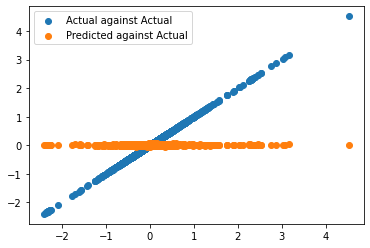

In [57]:
import matplotlib.pyplot as plt 

  
# plot lines 
plt.scatter(y_test, y_test, label = "Actual against Actual") 
plt.scatter(y_test, y_pred, label = "Predicted against Actual") 
plt.legend() 
plt.show()